# Creating Reduced Version of Crash Data

This file will simply subset the huge crash data by working only with the crash-indexed (as opposed to the vehicle- and person-indexed) file, subsetting its temporal range, removing unnecessary columns (for this analysis), and ensuring spatial integrity (checking that points are geotagged inside of Connecticut)

The data used for this step is the ALL INJURY CRASHES subset of the full crash data, subsetted from the CT Crash Data Repository

In [3]:
# Package Import
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Data Import

## Crash Data
df_0 = pd.read_csv("../data/CT_crashes/export_5673_0.csv", encoding="cp1252", skiprows=1)
df_0 = df_0.head()
### Names of geocode columns
lon_col, lat_col = "Longitude", "Latitude"
### Build geometry column:
geometry = gpd.points_from_xy(df_0[lon_col], df_0[lat_col])
crashes_gdf = gpd.GeoDataFrame(
    df_0,
    geometry=geometry,
    crs="EPSG:4326"  # WGS84 (latitude/longitude)
)

## CT Shapefile
ct_outline_gdf = gpd.read_file("../data/ct_shapefile/Connecticut_Poly.shp")
### Reproject CT shapefile to match crash points
if ct_outline_gdf.crs != crashes_gdf.crs:
    ct_outline_gdf = ct_outline_gdf.to_crs(crashes_gdf.crs)

/var/folders/lt/90cmmvp91vn9qgdwpxyyb6l40000gn/T/ipykernel_1647/2635688271.py:9: DtypeWarning: Columns (32,84,100,102) have mixed types. Specify dtype option on import or set low_memory=False.
  df_0 = pd.read_csv("../data/CT_crashes/export_5673_0.csv", encoding="cp1252", skiprows=1)


In [7]:
print(df_0.columns)

Index(['CrashId', 'Fatal Case Status', 'Fatal Case Status Text Format',
       'CrashId.1', 'CrashId.2', 'Latitude', 'Longitude', 'DOT Case Number',
       'Town Name', 'Town Number',
       ...
       'Police Case Status', 'Police Case Status Text Format',
       'Crash Report Submission Date', 'Related Case Identifiers',
       'No. of Through Lanes (Log Dir.)', 'Average Daily Traffic',
       'Functional Classification', 'Functional Classification Text Format',
       'Rural or Urban', 'Rural or Urban Text Format'],
      dtype='object', length=103)


In [11]:
# Cut range of data to (1/1/21-12/31/25)
### NOTE: CHECK HOW MANY ENTRIES LOST HERE! 
df_0 = df_0.dropna(subset=[lon_col, lat_col])

# Ensure that entries' locations are within Connecticut
## Unite CT polygons into a single geometry
ct_union = ct_outline_gdf.geometry.union_all()
## Create field to show which points fall within Connecticut boundary
crashes_gdf["inside_ct"] = crashes_gdf.geometry.within(ct_union)

## Report the number (and proportion) of entries with incorrect geocodes
n_total = len(crashes_gdf)
n_outside = (~crashes_gdf["inside_ct"]).sum()
prop_outside = n_outside / n_total

print(f"Total records: {n_total}")
print(f"Records outside Connecticut: {n_outside}")
print(f"Proportion outside Connecticut: {prop_outside:.4%}")

## Remove entries with locations outside Connecticut
crashes_ct_gdf = crashes_gdf[crashes_gdf["inside_ct"]].copy()
crashes_ct_gdf = crashes_ct_gdf.drop(columns="inside_ct")

# Filter Columns
keep_cols = [
        "geometry",
        "CrashId",
        "Fatal Case Status",
        "Latitude",
        "Longitude",
        "Date Of Crash",
        "Day of the Week",
        "Day of the Week Text Format",
        "Hour of the Day",
        "Most Severe Injury",
        "Number Of Motor Vehicles",
        "Number Of Non-Motorist",
        "Route Class", "Route Class Text Format",
        "First Harmful Event",
        "Manner of Crash / Collision Impact",
        "Location of First Harmful Event",
        "Weather Condition", "Weather Condition Text Format",
        "Light Condition", "Light Condition Text Format",
        "Road Surface Condition", "Road Surface Condition Text Format",
        "Crash Specific Location", "Crash Specific Location Text Format",
        "Type of Intersection", "Type of Intersection Text Format"
    ]

crashes_ct_gdf = crashes_ct_gdf[keep_cols]

# Export
crashes_ct_gdf.to_file(
    "../data/CT_crashes/ct_crashes_clean.geojson",
    driver="GeoJSON"
)

Total records: 5
Records outside Connecticut: 0
Proportion outside Connecticut: 0.0000%


<Axes: >

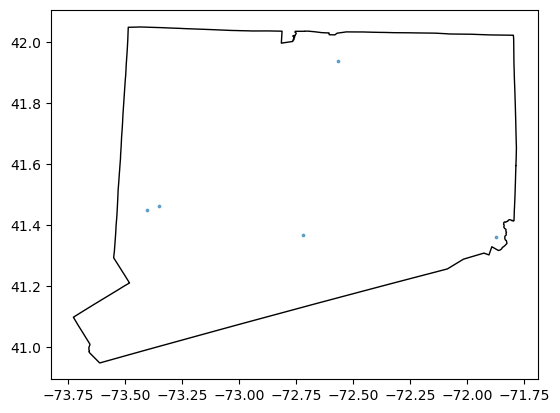

In [14]:
## VERIFICATION OF METHOD

gdf = gpd.read_file("../data/CT_crashes/ct_crashes_clean.geojson")

# Subsample (e.g., 200 random points)
gdf_sample = gdf.sample(n=5, random_state=5095)

ct = gpd.read_file("../data/ct_shapefile/Connecticut_Poly.shp").to_crs(gdf.crs)

ax = ct.plot(color="white", edgecolor="black")
gdf_sample.plot(ax=ax, markersize=3, alpha=0.6)